In [ ]:
# !git clone https://github.com/abeot/Adverse-effect-prediction.git --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Adverse-effect-prediction-main/

/content/drive/MyDrive/Adverse-effect-prediction-main


In [ ]:
# ! pip uninstall dgl --quiet

Proceed (Y/n)? y


In [ ]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.3.0+cu121
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

In [ ]:
# ! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 MB 3.2 MB/s eta 0:00:00


In [ ]:
# ! pip uninstall dgllife --quiet -y

In [ ]:
! pip install dgllife --quiet

In [ ]:
! pip uninstall numpy -y --quiet
! pip install numpy==1.24.4 --quiet

In [ ]:

## CONSTANTS
lr = 1e-5 # learning rate, try 1e-5
wd = 1e-5 # weight decay try 1e-5
best_epoch = 0
MAX_EPOCH = 300

# BELOW IS NOT CHANGEABLE
in_dim = 215
# best_cohen = 0.19
k_folds = 5

# model_path = f'test_{ae_name}.pt'

patience = 15
verbose_freq = 100 # print out results every 10 epochs
batch_size = 64
best_cohen_dict  = {
    'diarrhoea': 0.273,
    'dizziness': 0.31,
    'headache': 0.3187,
    'nausea': 0.2935,
    'vomiting': 0.27
}
# params = {'batch_size':batch_size, 'shuffle':False,
            #   'drop_last':False, 'num_workers': 0}

## Code

In [ ]:
import pandas as pd
from utils import *

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        try:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        except:
            print(f'cannot normalize {feature_name}')
    return result

### HANDEL MISSING DATA AS LABEL 0, EXISTING DATA AS LABEL !

# import pandas as pd
# import numpy as np

# data = pd.read_csv('/content/drive/MyDrive/Adverse-effect-prediction-main/drug_ml_info_binary_1.csv')
# aes  = [
#     'diarrhoea',
#     'dizziness',
#     'headache',
#     'nausea',
#     'vomiting'
# ]

# for j in range(len(aes)):
#     label_list = data[aes[j]].tolist()
#     temp_list = []

#     for i in label_list:
#         if np.isnan(i):
#             temp_list.append(0)
#         else: temp_list.append(1)

#     new_data = data.iloc[:,:-5].copy()
#     new_data = normalize(new_data)
#     new_data[aes[j]] = pd.DataFrame(temp_list)
#     new_data.to_csv(f"{aes[j]}_new.csv", index=False)

def get_data(ae_name, negative_sampling=None):
    # df = pd.read_csv(f'data_normalized_{ae_name}.csv')
    df = pd.read_csv(f'{ae_name}_new.csv')
    df = df.drop(columns=['drug', 'SMILES'])
    # df = normalize(df)
    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)
    for train_index, test_index in split.split(df, df[ae_name]):
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]

    if negative_sampling != None:
        counts = train_df[ae_name].value_counts()
        print('previous:', counts)
        count_0 = counts[0]
        count_1 = counts[1]
        negative_df = train_df.loc[train_df[ae_name] == 0]
        while count_0 < count_1*negative_sampling:
            train_df = pd.concat([train_df, negative_df], ignore_index=True)
            counts = train_df[ae_name].value_counts()
            count_0 = counts[0]
            count_1 = counts[1]
        print('After adding negative samples', counts)
    return df, train_df, test_df



In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pickle
import numpy as np

class Classifier(nn.Module):
    def __init__(self, in_dim, h_dims:list):
        super(Classifier, self).__init__()

        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        # self.emb = nn.GRU(h_dims[-1], h_dims[-1])
        self.final = nn.Linear(h_dims[-1], 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        # x = torch.squeeze(self.output(self.final(x)))
        x = torch.squeeze(self.output(self.final(x)))
        return x

class tox_dataset(Dataset):
    def __init__(self, df, ae_name):
        self.len = len(df)
        self.df = df
        self.ic_start_ind = df.columns.get_loc("appendix endocrine cells")
        self.ae_start_ind = df.columns.get_loc(ae_name)

    def __getitem__(self, idx):
        """
        OUTPUT
        :param fp: fingerprint, should be 167 dim
        :param ic: drug tissue concentration
        :param ae: adverse events
        """
        # header = ['bit' + str(i) for i in range(167)]
        # fp = self.df[header]
        # fp = torch.tensor([float(b) for b in fp.iloc[idx]], dtype=torch.float32)
        ic = self.df.iloc[:, self.ic_start_ind:self.ae_start_ind]
        ic = torch.tensor(ic.values.astype(np.float32))[idx]
        ae = self.df.iloc[:, self.ae_start_ind:]
        ae = torch.tensor(ae.values.astype(np.float32))[idx]
        # ae = onehot(5)(ae) # use onehot
        # return fp, ic, ae.float()
        return ic, ae.float()
    def __len__(self): return self.len

def loss_func(output, target, weight):

    target = target.to(dtype=torch.float32)

    output.requires_grad_(True)
    target.requires_grad_(True)

    log_output = torch.log(torch.clamp(output, min=1e-10, max=1.0 - 1e-10))
    log_1_minus_output = torch.log(torch.clamp(1 - output,
                                    min=1e-10, max=1.0 - 1e-10))

    loss = -torch.sum(target * log_output + \
            weight * (1 - target) * log_1_minus_output)

    return loss

def train_epoch(model, loader, device='cpu', epoch=None, optimizer=None,
                MASK=-100, model_type='MLP', weight_loss=None, ver=False, ae_name=""):
    if optimizer==None: # no optimizer, either valid or test
        model.eval()
        if epoch != None: train_type = 'Valid'
        else: train_type = 'Test'
    else: model.train(); train_type='Train'

    if weight_loss == None:
        weight_loss = 1.0
    total_loss, y_probs, y_label = 0, {}, {}

    for idx, batch_data in enumerate(loader):
        # fp, ic, ae = batch_data
        # fp, ic, ae = fp.to(device), ic.to(device), ae.to(device)
        ic, ae = batch_data
        ic, ae = ic.to(device), ae.to(device)
        mask = ae == MASK
        mask = mask.to(device)
        # pred = model(torch.cat((fp, ic), 1))
        pred = model(ic)
        # print('pred', pred)

        loss = loss_func(pred, ae, weight_loss)

        if train_type != 'Train': # valid or test, output probs and labels
            probs = pred.cpu().detach().numpy().tolist()
            label = ae.cpu().detach().numpy().tolist()
            # print(probs, type(probs), label, type(label))
            if isinstance(probs, float): probs = [probs]
            if isinstance(label, float): label = [label]
            if idx == 0: y_probs, y_label = probs, label
            else: y_probs += probs; y_label += label

        total_loss += loss.item() # sum up all loss for all AE in this batch
        # print(total_loss)
        if optimizer != None:
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    total_loss /= len(loader)
    if epoch != None: # train or valid
        if ver: print(f'Epoch:{epoch}, [{train_type}] loss: {total_loss:.3f}')
    elif epoch == None: # test
        if ver: print(f'[{train_type}] loss: {total_loss:.3f}')
        # print(y_probs, y_label)
        performance = eval_dict(y_probs, y_label, False,
                                'MLP', draw_fig=True, ae_name=ae_name)
        # performance = float(total_loss)

    if   train_type == 'Train': return total_loss, y_probs, y_label
    elif train_type == 'Valid': return total_loss, y_probs, y_label
    else: return performance, y_probs, y_label

def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

def eval(model, loader, path=None, ae_name="", device='cpu'):
    if path != None: load_model(model, path)
    performance, probs, label = train_epoch(model, loader, device=device, ae_name=ae_name)
    return performance, probs, label


from dgllife.utils import EarlyStopping



def train(model, data_loader, val_loader, test_loader=None, weight_loss=None,
          ver_freq=verbose_freq, optimizer=None, ae_name="", device='cuda', model_path=None):
    train_dict = {}
    valid_dict = {}
    min_loss = np.inf
    if model_path == None: model_path = f'test_{ae_name}.pt'

    ### MOD:
    # stopper was put inside function train instead of outside.
    # Otherwise you are using the same stopper for 5-fold validation
    stopper = EarlyStopping(mode='lower', patience=patience)


    for epoch in range(best_epoch, MAX_EPOCH):
        score, _, _ = train_epoch(model, data_loader, epoch=epoch,
                optimizer=optimizer, weight_loss=weight_loss, device=device)
        val_score, probs, labels = train_epoch(model, val_loader,
                epoch=epoch, weight_loss=weight_loss, device=device)
        print(f'Epoch:{epoch} [Train] Loss:{score:.3f} | ',
              f'[Valid] Loss: {val_score:.3f}', end='\t')
        train_dict[epoch] = score
        valid_dict[epoch] = val_score

        early_stop = stopper.step(val_score, model)
        if val_score < min_loss:
            print(f'SAVE MODEL: loss drop: {min_loss:.3f} -> {val_score:.3f}')
            min_loss = val_score
            torch.save(model.state_dict(), model_path)

        if epoch % ver_freq == 0 and epoch != 0:
            plot_loss(train_dict, valid_dict, name='valid',
            title_name="loss during training MLP")
            eval_dict(probs, labels, False, 'MLP', ae_name=ae_name)

        if early_stop: print('early stop'); break

    print('Finished training \n')
    # clean_files() # delete all .pth files, use with caution

    plot_loss(train_dict, valid_dict, name='valid',
            title_name="loss during training MLP")

    if test_loader != None:
        performance, _, _ = eval(model, test_loader, model_path,
                                 device=device, ae_name=ae_name)
        return performance

In [ ]:
import torch.optim as optim
from dgllife.utils import EarlyStopping
from sklearn.model_selection import KFold
import pickle
# hidden dims of neural network are changeable,
# as long as its all integers
# h_dims = [400*2, 256*2, 128*2, 128, 64]

def get_max(d:dict):
    max_key = next(iter(d))
    for key in d:
        if d[key] > d[max_key]: max_key = key
    return max_key, d[max_key]


def batch_train(ae_name, model_file, k_folds,
                min_weight, max_weight, weight_interval,
                negative_sampling=None, best_cohen=0.15, batch_size=64):

    _, train_df, test_df = get_data(ae_name, negative_sampling=negative_sampling)

    with open(f'{model_file}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

    temp_min = int(min_weight/weight_interval)
    temp_max = int(max_weight/weight_interval)
    kf = KFold(n_splits=k_folds, shuffle=True)

    model_path = f'{model_file}/test_{ae_name}.pt'

    train_dataset = tox_dataset(train_df, ae_name)
    params = {'batch_size':batch_size, 'shuffle':False,
              'drop_last':False, 'num_workers': 0}
    test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)

    # weight_losses = [0.2, 8.0, 8.0, 7.0, 6.0]

    result_dict = {}

    for idx_here in range(temp_min, temp_max):
        print('\n\n')
        weight_loss_here = idx_here * weight_interval
        print('*'*40, weight_loss_here, '*'*40)

        result_list = []

        for repeat_time in range(3):

            results = {
                "acc": [],
                "precision": [],
                "recall": [],
                "F1": [],
                "TP": [],
                "TN": [],
                "FP": [],
                "FN": [],
                "cohen": []
            }
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                print(f"Fold {fold + 1}/{k_folds}, batch_size={batch_size},", end="")
                print(f"negative sampling={negative_sampling}, weight {weight_loss_here}, {ae_name}, {model_file}")
                print("-------")

                stopper = EarlyStopping(mode='lower', patience=patience)
                train_loader = DataLoader(
                    train_dataset,
                    batch_size=batch_size,
                    sampler=torch.utils.data.SubsetRandomSampler(train_idx),
                )
                val_loader = DataLoader(
                    train_dataset,
                    batch_size=batch_size,
                    sampler=torch.utils.data.SubsetRandomSampler(val_idx),
                )

                model = Classifier(in_dim, h_dims)
                if torch.cuda.is_available(): model = model.cuda()
                optimizer = optim.AdamW(params=model.parameters(),
                                        lr=lr, weight_decay=wd)

                cls_results = train(model, train_loader, val_loader, test_loader,
                        weight_loss=weight_loss_here, optimizer=optimizer,
                        ae_name=ae_name, device='cuda', model_path=model_path)
                # _, probs, label = eval(model, test_loader, model_path, device='cuda')
                # preds = get_preds(0.5, probs)
                # cls_results = evaluate(label, preds, probs)
                # print('cls_results:', cls_results)
                cohen_here = cls_results['cohen']
                if cohen_here > best_cohen:
                    try: file_old_path = file_new_path
                    except: file_old_path = 'not_find_this_file'
                    print('save model, best cohen by now =', cohen_here)
                    file_new_path = f'{model_file}/{ae_name}_cohen_{cohen_here}.pt'
                    torch.save(model.state_dict(), file_new_path)
                    import os
                    file_path = f'{ae_name}_cohen_{best_cohen}.pt'
                    if os.path. exists(file_old_path):
                        os.remove(file_old_path)
                        print(f"The file {file_old_path} has been deleted.")
                    best_cohen = cohen_here

                # [ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP]
                for key in cls_results:
                    results[key].append(cls_results[key])

                # if cls_results['cohen'] == 0:
                #     break
            for key in results:
                results[key].append(np.mean(results[key]))

            results_df = pd.DataFrame.from_dict(results)
            cohen_here = results_df['cohen'].tolist()[-1]
            result_list.append(cohen_here)
            if cohen_here == 0: break

        result_dict[weight_loss_here] = sum(result_list) / len(result_list)
        if result_dict[weight_loss_here] < 0: break

        # argmax_cohen, max_cohen = get_max(result_dict)
        # if len(result_dict) > argmax_cohen + 3: break

    # clean_files()
    return result_dict
# results_df.to_csv(f"{ae_name}_results.csv", index=False)

## Experiment (Do not run, cost several days)

In [ ]:
# h_dims = [1600, 1028, 512, 216, 128]
# model_file = 'best_models_3'
# import pickle
# # model_file = 'best_models_1'
# with open(f'{model_file}/h_dims.pkl', 'wb') as f: pickle.dump(h_dims, f)
# with open(f'{model_file}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)
# h_dims

clean_files()

In [ ]:
h_dims = [800, 512, 216, 128, 64]
model_file = 'new_models'
import pickle
# model_file = 'best_models_1'
with open(f'{model_file}/h_dims.pkl', 'wb') as f: pickle.dump(h_dims, f)
with open(f'{model_file}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)
h_dims


[800, 512, 216, 128, 64]

In [ ]:
aes[-2:]

['nausea', 'vomiting']

In [ ]:
best_cohen_dict  = {
    'diarrhoea': 0.,
    'dizziness': 0.,
    'headache': 0.,
    'nausea': 0.,
    'vomiting': 0.
}

for model_file in ['new_models']:
    for k_folds in range(6, 7):
        k_folds = int(k_folds)
        for batch_size in [64]:
            for ns in [None]:
                for ae_name in aes[-2:]:
                # for ae_name in ['vomiting']:
                    best_cohen = best_cohen_dict[ae_name]
                    result_dict = batch_train(ae_name, model_file, k_folds,
                                min_weight=0.5, max_weight=4, weight_interval=0.5,
                                negative_sampling=ns, best_cohen=best_cohen,
                                batch_size=batch_size)
#                     if result_dict != None:
#                         break
#                 break
#             break
#         break
#     break
# result_dict

In [ ]:
model_file = 'best_models_2'

# h_dims = [400, 256, 128, 64]

# h_dims =  [200, 128, 64, 32]
# import pickle
# # model_file = 'best_models_1'
# with open(f'{model_file}/h_dims.pkl', 'wb') as f: pickle.dump(h_dims, f)
# with open(f'{model_file}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)
# h_dims

for i in tqdm(range(9,1,-1), desc=f'current'):
    max_weight = min(int(10/i) + 3, 9)
    min_weight = max(min(max(int(10/i) - 3, 1), max_weight-4), 0.2)
    # print('min max:', min_weight, max_weig)ht)
    for _, ae_name in tqdm(enumerate(['headache', 'nausea',
                                      'vomiting', 'dizziness',
                                      'diarrhoea']),
                           total=5, desc=f'current ae, i= {i}'):

        result_dict = batch_train(ae_name, model_file, k_folds,
                            min_weight=min_weight, max_weight=max_weight,
                            weight_interval=0.2,
                            negative_sampling=0.1*i, best_cohen=0.2)

In [ ]:
for i in range(1,10):
    # max_weight = min(int(10/i) + 3, 9)
    # min_weight = max(min(max(int(10/i) - 3, 1), max_weight-4), 0.2)
    max_weight = 9
    min_weight = 1
    print('min max:', min_weight, max_weight)
    for ae_name in ['dizziness']:
        result_dict = batch_train(ae_name, model_file, k_folds,
                            min_weight=min_weight, max_weight=max_weight,
                            weight_interval=0.2,
                            negative_sampling=0.1*i, best_cohen=0.00001)

In [ ]:
# for i in range(1,10):
#     max_weight = min(int(10/i) + 3, 9)
#     min_weight = max(min(max(int(10/i) - 3, 1), max_weight-4), 0.2)
#     print('min max:', min_weight, max_weight)

# Results

Parameter tested:

* h_dims:  
  
```
  [1000, 512, 256, 128] - folder 'best_models'

  [400, 256, 128, 64].  - folder 'best_models_1'

  [200, 128, 64, 32]    - folder 'best_models_2'
```

* negative sampling 0.1 - 1, increment = 0. 1

* loss_weight, 1-9, increment = 0.2

---> further possible solution

* k_folds, 2-10, increment = 1

In [ ]:
clean_files()

## Results frequent AEs vs infrequent AEs

In [ ]:
# ae_name = 'diarrhoea'
# acc	   precision	recall	     F1	       TP	    TN	FP	FN	 cohen
# 0.929577	0.927536	1.000000	0.962406	64.0	2.0	5.0	0.0	0.418985

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/new_models/headache_cohen_0.05673758865248235.pt
***************  ***************
TN: 2; FP: 34; FN: 1; TP: 77
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.693  &0.521  &0.694  &0.987  &0.056  &0.815 &0.489 &0.124 &0.697 &0.057


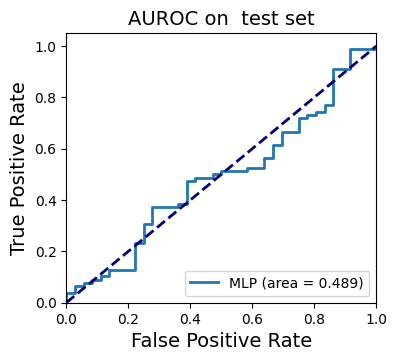

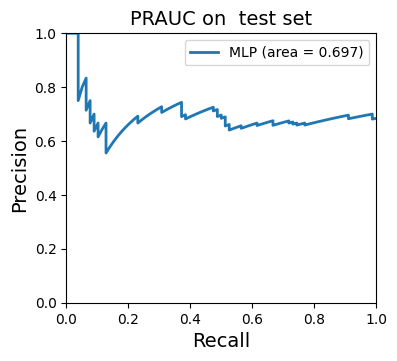

In [ ]:
model_folder = 'new_models'
ae_name = 'headache'

_, _, test_df = get_data(ae_name)
batch_size = 64
params = {'batch_size':batch_size, 'shuffle':False,
              'drop_last':False, 'num_workers': 0}

test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)


# with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)
# print(h_dims)


model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/new_models/headache_cohen_0.05673758865248235.pt'


# def eval(model, loader, path=None, device='cpu'):
#     if path != None: load_model(model, path)
#     performance, probs, label = train_epoch(model, loader, device=device)
#     return performance, probs, label

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/best_models/dizziness_cohen_0.3109869646182495.pt
***************  ***************
TN: 3; FP: 8; FN: 2; TP: 61
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.865  &0.620  &0.884  &0.968  &0.273  &0.924 &0.508 &0.342 &0.852 &0.311


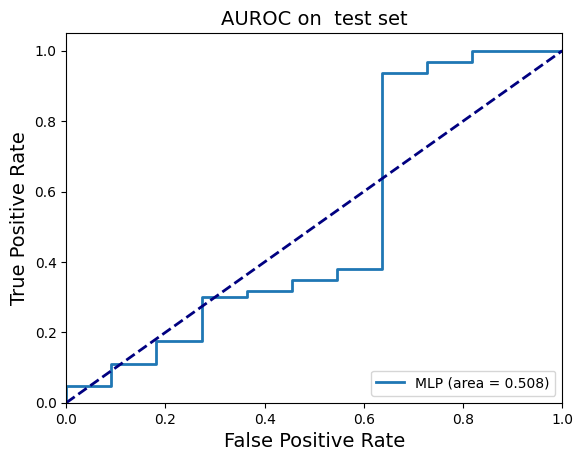

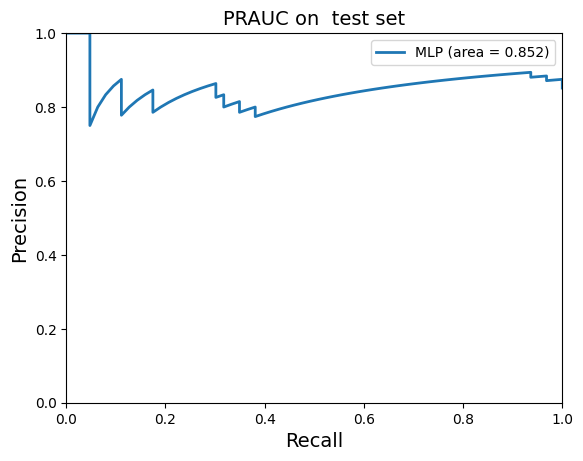

In [ ]:
model_folder = 'best_models'
ae_name = 'dizziness'

_, _, test_df = get_data(ae_name)
test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/best_models/dizziness_cohen_0.3109869646182495.pt'

# def eval(model, loader, path=None, device='cpu'):
#     if path != None: load_model(model, path)
#     performance, probs, label = train_epoch(model, loader, device=device)
#     return performance, probs, label

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/best_models/headache_cohen_0.4108761329305136.pt
***************  ***************
TN: 2; FP: 3; FN: 2; TP: 71
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.936  &0.686  &0.959  &0.973  &0.400  &0.966 &0.734 &0.414 &0.975 &0.411


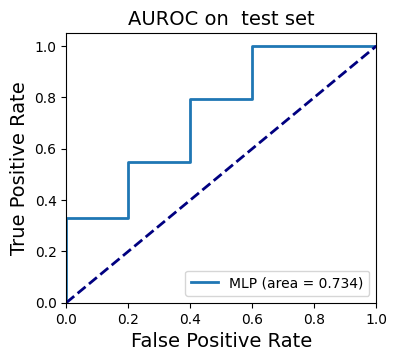

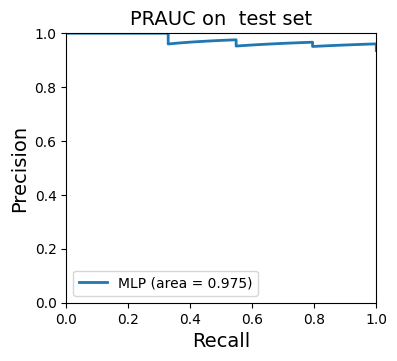

In [ ]:
model_folder = 'best_models'
ae_name = 'headache'

_, _, test_df = get_data(ae_name)
test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/best_models/headache_cohen_0.4108761329305136.pt'

# def eval(model, loader, path=None, device='cpu'):
#     if path != None: load_model(model, path)
#     performance, probs, label = train_epoch(model, loader, device=device)
#     return performance, probs, label

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/best_models/nausea_cohen_0.4134078212290503.pt
***************  ***************
TN: 2; FP: 3; FN: 2; TP: 77
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.940  &0.687  &0.963  &0.975  &0.400  &0.969 &0.663 &0.416 &0.953 &0.413


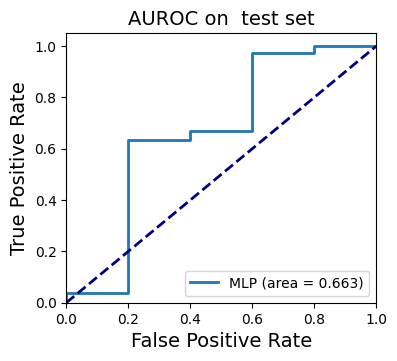

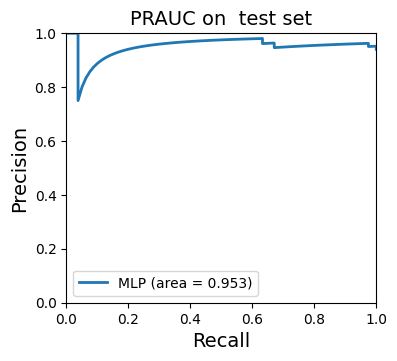

In [ ]:
model_folder = 'best_models'
ae_name = 'nausea'

_, _, test_df = get_data(ae_name)
test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/best_models/nausea_cohen_0.4134078212290503.pt'

# def eval(model, loader, path=None, device='cpu'):
#     if path != None: load_model(model, path)
#     performance, probs, label = train_epoch(model, loader, device=device)
#     return performance, probs, label

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/best_models/vomiting_cohen_0.29735234215885953.pt
***************  ***************
TN: 5; FP: 2; FN: 13; TP: 49
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.783  &0.752  &0.961  &0.790  &0.714  &0.867 &0.675 &0.347 &0.951 &0.297


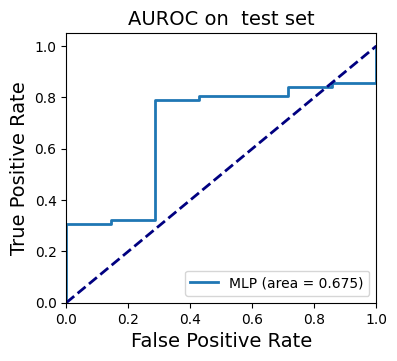

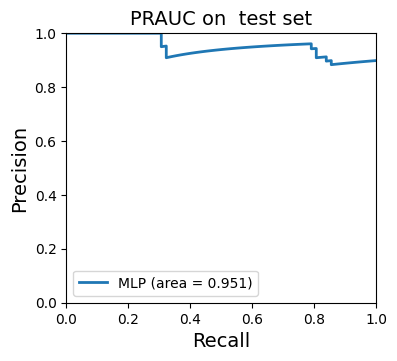

In [ ]:
model_folder = 'best_models'
ae_name = 'vomiting'

_, _, test_df = get_data(ae_name)
test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/best_models/vomiting_cohen_0.29735234215885953.pt'
# def eval(model, loader, path=None, device='cpu'):
#     if path != None: load_model(model, path)
#     performance, probs, label = train_epoch(model, loader, device=device)
#     return performance, probs, label

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/best_models_3/vomiting_cohen_0.29735234215885953.pt
***************  ***************
TN: 5; FP: 2; FN: 13; TP: 49
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.783  &0.752  &0.961  &0.790  &0.714  &0.867 &0.677 &0.347 &0.950 &0.297


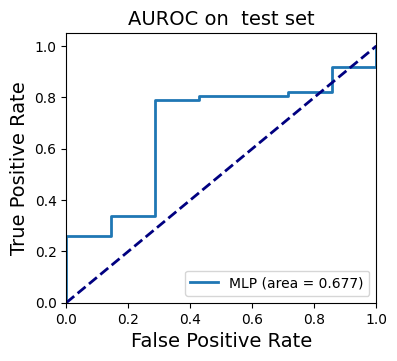

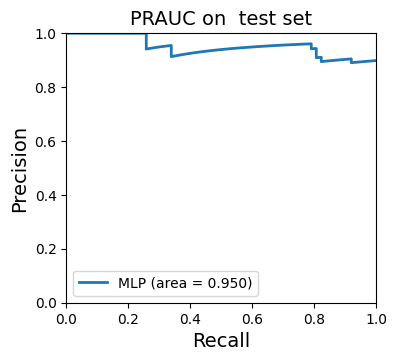

In [ ]:
model_folder = 'best_models_3'
ae_name = 'vomiting'

_, _, test_df = get_data(ae_name)
test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

model = Classifier(in_dim, h_dims)
if torch.cuda.is_available(): model = model.cuda()
model_path_best_cohen = '/content/drive/MyDrive/Adverse-effect-prediction-main/best_models_3/vomiting_cohen_0.29735234215885953.pt'

_ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')

## Results for AE vs non-AE




 headache
load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/new_models/headache_cohen_0.05673758865248235.pt
***************  ***************
TN: 2; FP: 34; FN: 1; TP: 77
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.693  &0.521  &0.694  &0.987  &0.056  &0.815 &0.489 &0.124 &0.697 &0.057


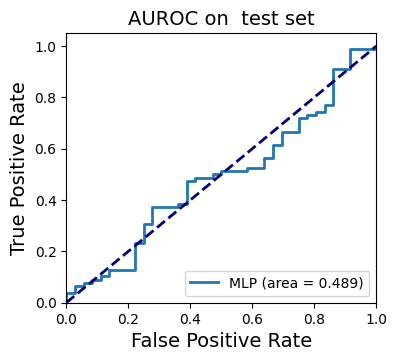

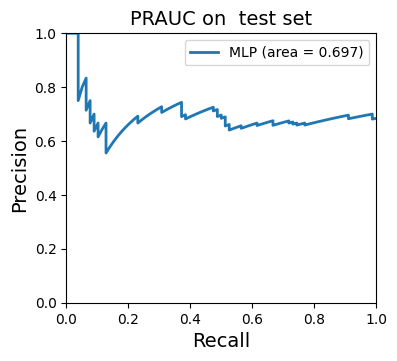





 diarrhoea
load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/new_models/diarrhoea_cohen_0.04309696817840136.pt
***************  ***************
TN: 43; FP: 0; FN: 67; TP: 4
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.412  &0.528  &1.000  &0.056  &1.000  &0.107 &0.497 &0.148 &0.648 &0.043


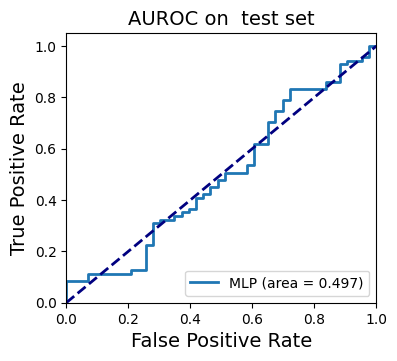

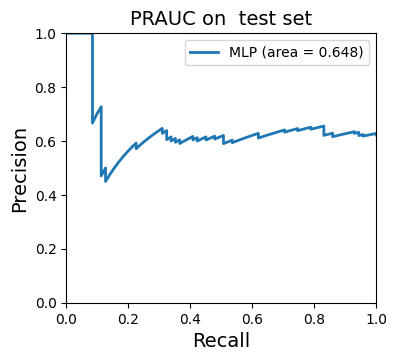





 vomiting
load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/new_models/vomiting_cohen_0.0010621348911311612.pt
***************  ***************
TN: 42; FP: 4; FN: 62; TP: 6
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.421  &0.501  &0.600  &0.088  &0.913  &0.154 &0.450 &0.002 &0.582 &0.001


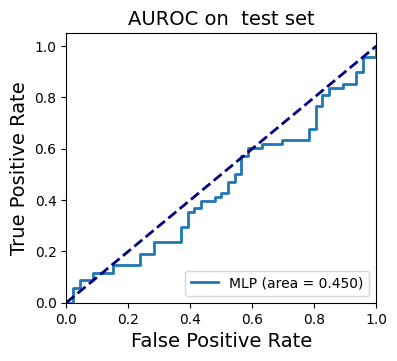

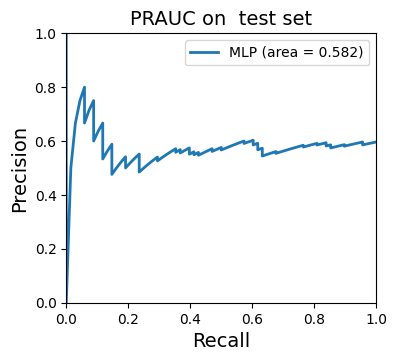





 dizziness
load model from path:  /content/drive/MyDrive/Adverse-effect-prediction-main/new_models/dizziness_cohen_0.014693171996542853.pt
***************  ***************
TN: 1; FP: 39; FN: 1; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP    Cohen
&0.649  &0.506  &0.652  &0.986  &0.025  &0.785 &0.510 &0.042 &0.638 &0.015


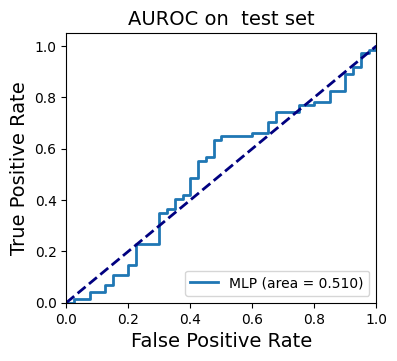

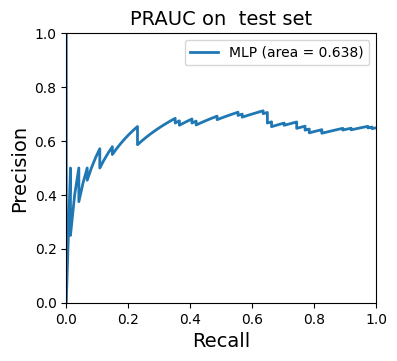

In [ ]:
result_dict_no_vs_AE = {'headache': '/content/drive/MyDrive/Adverse-effect-prediction-main/new_models/headache_cohen_0.05673758865248235.pt',
                        'diarrhoea': '/content/drive/MyDrive/Adverse-effect-prediction-main/new_models/diarrhoea_cohen_0.04309696817840136.pt',
                        'vomiting': '/content/drive/MyDrive/Adverse-effect-prediction-main/new_models/vomiting_cohen_0.0010621348911311612.pt',
                        'dizziness': '/content/drive/MyDrive/Adverse-effect-prediction-main/new_models/dizziness_cohen_0.014693171996542853.pt'}

model_folder = 'new_models'
for ae_name, model_path_best_cohen in result_dict_no_vs_AE.items():
    # print(i, j)
    params = {'batch_size':batch_size, 'shuffle':False,
              'drop_last':False, 'num_workers': 0}
    _, _, test_df = get_data(ae_name)
    test_loader = DataLoader(tox_dataset(test_df, ae_name), **params)
    with open(f'{model_folder}/h_dims.pkl', 'rb') as f: h_dims = pickle.load(f)

    model = Classifier(in_dim, h_dims)
    if torch.cuda.is_available(): model = model.cuda()
    print('\n\n\n', ae_name)
    _ = eval(model, test_loader, path=model_path_best_cohen, device='cuda')